# Part 3 Solutions

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import yfinance as yf
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
import datetime

from src.styles import FinanceStyles
fs = FinanceStyles()


# 1

In [2]:
ticker = "AAPL"
start_date = "2001-01-01"
end_date = "2023-01-01"
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
adjusted_close = data["Adj Close"].values
print(data.head(5))


[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2001-01-02  0.223821  0.265625  0.272321  0.260045  0.265625  452312000
2001-01-03  0.246392  0.292411  0.297991  0.257813  0.258929  817073600
2001-01-04  0.256736  0.304688  0.330357  0.300223  0.323940  739396000
2001-01-05  0.246392  0.292411  0.310268  0.286830  0.302455  412356000
2001-01-08  0.249213  0.295759  0.303292  0.284598  0.302455  373699200


The historical estimator of the mean is given by:  0.0014093301959502988


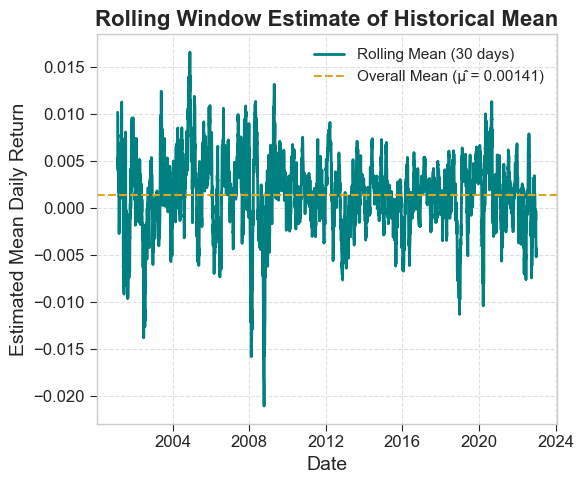

In [3]:
# Calculate daily returns and squared returns
t = np.arange(len(adjusted_close))
N = len(adjusted_close)
mu_list = []

for i in range(N-1):
    mu = (1/(t[i+1] - t[i])) * ((adjusted_close[i+1] - adjusted_close[i]) / adjusted_close[i])
    mu_list.append(mu)

mu_hat = np.sum(mu_list) / N

print("The historical estimator of the mean is given by: ", mu_hat)

mu_series = pd.Series(mu_list, index=data["Adj Close"].index[1:])

rolling_mu = mu_series.rolling(window=30).mean()

plt.figure(figsize=(6, 5))
plt.plot(rolling_mu, color='#008080', linewidth=2, label="Rolling Mean (30 days)")
plt.axhline(mu_hat, color='#daa520', linestyle='--', label=f"Overall Mean (μ̂ = {mu_hat:.5f})")
plt.title("Rolling Window Estimate of Historical Mean", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Estimated Mean Daily Return", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
path = "src/figures/p1/rolling_mean_estimate.png"
plt.savefig(path, dpi=300)
plt.show()

In [4]:
sigma_list = []
for i in range(N-1):
    sigma = (1/(t[i+1] - t[i])) * ((adjusted_close[i+1] - adjusted_close[i]) / adjusted_close[i] - (t[i+1] - t[i])*mu_hat)**2
    sigma_list.append(sigma)

sigma_hat_squared = np.sum(sigma_list) / (N - 1)
sigma_hat = np.sqrt(sigma_hat_squared)
print("The historical estimator of the volatility is given by: ", sigma_hat)


The historical estimator of the volatility is given by:  0.02285750042751558


In [5]:
high = data["High"].values
low = data["Low"].values
close = data["Close"].values
open_ = data["Open"].values

T = len(high)

sum_hl = np.sum((np.log(high / low))**2)

sum_co = np.sum((np.log(close / open_))**2)

sigma_gk = np.sqrt(
    (1.0 / (2.0 * T)) * sum_hl
    - (((2.0 * np.log(2)) - 1.0) / T) * sum_co
)

print("The Garman-Klass estimator of the volatility is given by: ", sigma_gk)

The Garman-Klass estimator of the volatility is given by:  0.019465371561795664


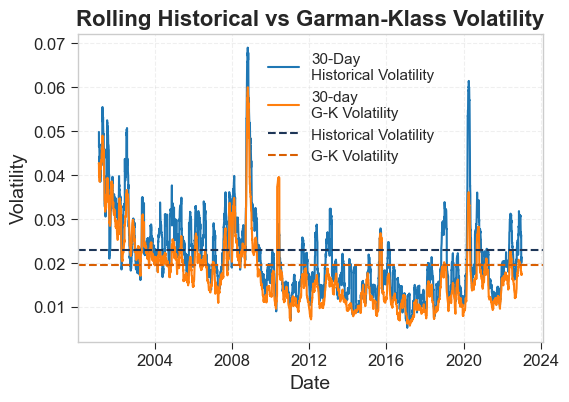

In [6]:
window = 30
data["Return"] = data["Close"].pct_change()

def calc_rolling_vol(returns, mu_hat):
    # Number of prices in the window
    W = len(returns)
    
    # Number of returns is one less than the number of prices
    N = W - 1  
    if N < 2:
        return np.nan
   
    variance_terms = (returns - mu_hat)**2
    sigma_sq = np.sum(variance_terms) / (N - 1)
    return np.sqrt(sigma_sq)

data["Rolling_Vol"] = data["Return"].rolling(window=window).apply(calc_rolling_vol, args=(mu_hat,), raw=True)

data['HL_Log'] = np.log(data['High'] / data['Low'])**2
data['CO_Log'] = np.log(data['Close'] / data['Open'])**2

# Compute rolling sums for each term
data['Rolling_HL'] = data['HL_Log'].rolling(window=window).sum()
data['Rolling_CO'] = data['CO_Log'].rolling(window=window).sum()
data['GkVol'] = np.sqrt((1 / (2 * window)) * data['Rolling_HL'] - ((2 * np.log(2) - 1) / window) * data['Rolling_CO'])

path = "src/figures/p1/historical_and_garman_klass_volatility.png"

plt.figure(figsize=(6, 4))
plt.plot(data.index, data["Rolling_Vol"], label='30-Day\nHistorical Volatility', color="#1F77B4")
plt.plot(data.index, data["GkVol"], label='30-day\nG-K Volatility', color='#FF7F0E')
plt.axhline(sigma_hat, color='#1d3557', linestyle='--', label="Historical Volatility")
plt.axhline(sigma_gk, color='#d95f02', linestyle='--', label="G-K Volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.title('Rolling Historical vs Garman-Klass Volatility',fontsize=16, fontweight='bold')
plt.legend(fontsize=11, bbox_to_anchor=(0.38, 0.985), loc='upper left')
plt.savefig(path, dpi=300, bbox_inches='tight')

plt.show()

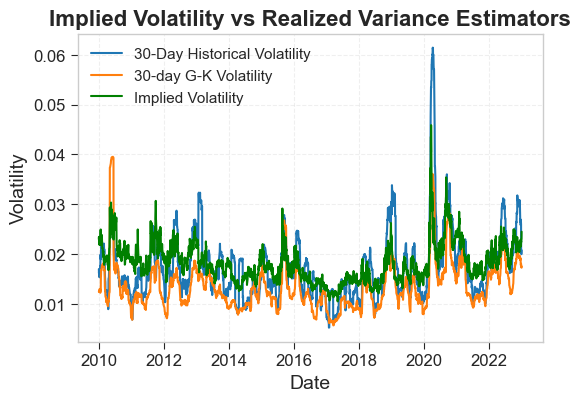

In [7]:
prices = load_sp500_dataset()
# Implied Volatility data from skfolio is only avaialble for 2010-today
implied_vol = load_sp500_implied_vol_dataset()
ticker = "AAPL"
prices_single = prices[[ticker]]
implied_vol_single = implied_vol[[ticker]]
# Rescaled by amount of trading days in a year
implied_vol_single_rescaled = implied_vol_single / np.sqrt(252)

common_dates = data.index.intersection(implied_vol_single_rescaled.index)

data_aligned = data.loc[common_dates]
implied_vol_single_rescaled = implied_vol_single_rescaled.loc[common_dates]

plt.figure(figsize=(6, 4))
plt.plot(data_aligned.index, data_aligned["Rolling_Vol"], label='30-Day Historical Volatility', color="#1F77B4")
plt.plot(data_aligned.index, data_aligned["GkVol"], label='30-day G-K Volatility', color='#FF7F0E')
plt.plot(implied_vol_single.index, implied_vol_single_rescaled, label='Implied Volatility', color='green')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.title('Implied Volatility vs Realized Variance Estimators', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
path = "src/figures/p1/historical_garman_klass__implied_volatility.png"
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

In [10]:
spx_symbol = "^SPX"
today_string = "2025-03-05"
today = datetime.datetime.strptime(today_string, "%Y-%m-%d")
end_date = today
start_date = end_date - datetime.timedelta(days=365)
spx_data = yf.download(spx_symbol, start=start_date, end=end_date)

lastBusDay = spx_data.index[-1]
vix_data = yf.download(
    "^VIX", start=lastBusDay, end=lastBusDay + datetime.timedelta(days=1)
)
print(vix_data)
spx_ticker = yf.Ticker("^SPX")
expiry_date = "2025-04-28"
chain = spx_ticker.option_chain(expiry_date)

calls = pd.read_csv("src/data/Call_option_data_2025-04-03_final.csv")
calls = calls.reset_index(drop=True)
calls.drop(columns=["Unnamed: 0"], inplace=True)

puts = pd.read_csv("src/data/Put_option_data_2025-04-03_final.csv")
puts = puts.reset_index(drop=True)
puts.drop(columns=["Unnamed: 0"], inplace=True)

# Given by the assignment (CBOE)
tau = 30 / 365

# risk-free interest rate is set equal to US treasury yield for 30-days
r = 0.02
F = np.exp(r * tau) * spx_data["Close"].iloc[-1].values[0]
print(f"Forward Price F: {F}")

puts = puts[(puts["strike"] < F)]
calls = calls[(calls["strike"] > F)] 

# Where the put price is denoted by the average of the bid and ask prices
puts_component = (
    (((puts["bid"] + puts["ask"])/2) * ((1 / puts["strike"]) - (1 / puts["strike"].shift(-1))))
    .dropna()
    .sum()
)

calls_component = (
    (((calls["bid"] + calls["ask"])/2) * ((1 / calls["strike"].shift(1)) - (1 / (calls["strike"]))))
    .dropna()
    .sum()
)
summation = puts_component + calls_component
VIX = np.sqrt((((2 * np.exp(r * tau)) / tau) * summation))
print("VIX:", VIX * 100)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price       Close   High        Low       Open Volume
Ticker       ^VIX   ^VIX       ^VIX       ^VIX   ^VIX
Date                                                 
2025-03-04  23.51  26.35  21.709999  22.959999      0
Forward Price F: 5787.656042075254
VIX: 20.50555555472897


[*********************100%***********************]  1 of 1 completed


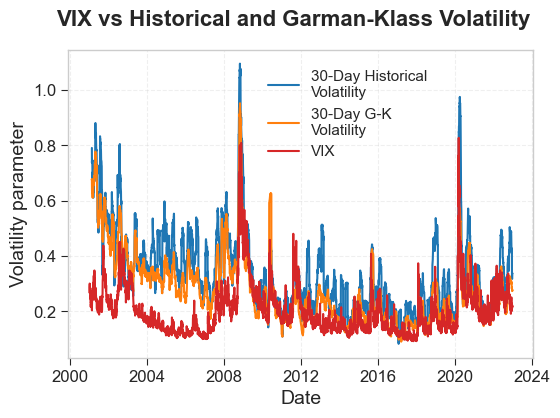

In [11]:
start_date = "2001-01-01"
end_date = "2023-01-01"

vix_data = yf.download(
    "^VIX", start=start_date, end=end_date
)

plt.figure(figsize=(6,4))
plt.plot(data.index, data["Rolling_Vol"] * np.sqrt(252), label='30-Day Historical \nVolatility', color='#1F77B4')
plt.plot(data.index, data["GkVol"] * np.sqrt(252), label='30-Day G-K \nVolatility', color='#FF7F0E')
plt.plot(vix_data.index, vix_data["Close"]/100, label='VIX', color='#D62728')
plt.ylabel("Volatility parameter", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.suptitle("VIX vs Historical and Garman-Klass Volatility", fontsize=16, fontweight='bold')
path = "src/figures/p1/vix_vs_historical_volatility_difference.png"
plt.grid(True)
plt.legend(bbox_to_anchor=[0.4,0.6], fontsize=11)
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()


In [12]:
def analyze_and_plot_volatility(cleaned_df, vol_col, color, label, filename):
    corr, p_value = stats.pearsonr(cleaned_df["VIX"], cleaned_df[vol_col])
    print(f"\nCorrelation between VIX and {label}: {corr:.3f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"The correlation is statistically significant (p-value: {p_value:.4f})")
    else:
        print(f"The correlation is NOT statistically significant (p-value: {p_value:.4f})")
    
    plt.figure(figsize=(6.5, 5))
    plt.scatter(
        cleaned_df[vol_col],
        cleaned_df["VIX"],
        alpha=0.25,
        s=50,
        color=color,
        edgecolors='w',
        linewidths=0.5,
        label=label
    )
    plt.title(f"VIX vs {label}\nCorr = {corr:.2f}, p = {p_value:.2f}", fontsize=16, weight='bold', pad=20)
    plt.xlabel(label, fontsize=14, labelpad=10)
    plt.ylabel("VIX", fontsize=14, labelpad=10)
    plt.grid(True, linewidth=0.5, linestyle='--', alpha=0.7)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

df = pd.concat([vix_data["Close"], data["Rolling_Vol"], data["GkVol"]], axis=1)
df.columns = ["VIX", "Rolling_Vol", "GkVol"]
cleaned_df = df.dropna().copy()
cleaned_df["VIX"] = cleaned_df["VIX"] / 100


Correlation between VIX and Garman-Klass Volatility: 0.595
The correlation is statistically significant (p-value: 0.0000)


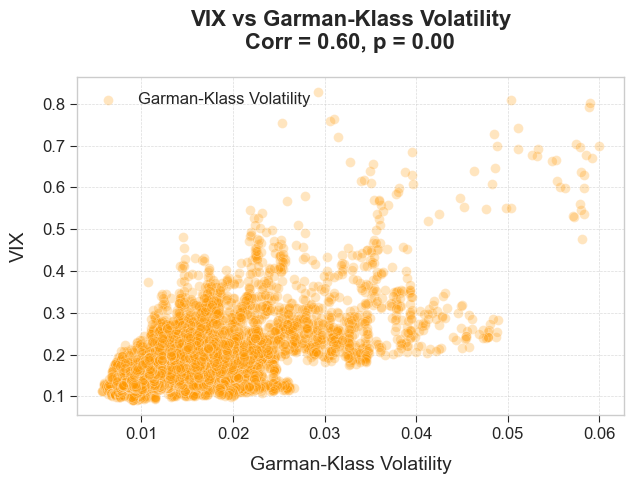


Correlation between VIX and Historical Volatility: 0.576
The correlation is statistically significant (p-value: 0.0000)


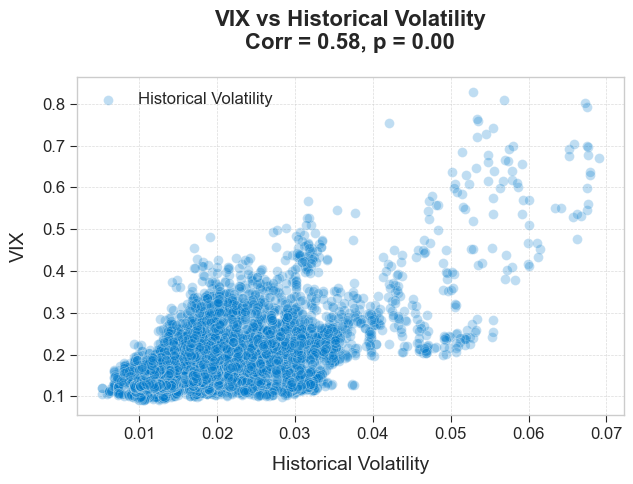

In [13]:
analyze_and_plot_volatility(cleaned_df, "GkVol", "#ff9900", "Garman-Klass Volatility", "src/figures/p1/vix_vs_gkvol.png")
analyze_and_plot_volatility(cleaned_df, "Rolling_Vol", "#007acc", "Historical Volatility", "src/figures/p1/vix_vs_hvol.png")

In [14]:
start_date = "2001-01-01"
end_date = "2023-01-01"

spx = yf.download(
    "^SPX", start=start_date, end=end_date
)

spx["Log_Return"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx.dropna(inplace=True)
vix_data["Close"] = vix_data["Close"] / 100
vix = vix_data.dropna().copy()

data_df = spx[["Log_Return"]].join(vix, how="inner")
data_df = data_df.join(data[["Rolling_Vol"]], how="inner")
data_df = data_df[["Log_Return", "Close", "Rolling_Vol"]].dropna().copy()

def run_regression_plot(x_col, x_label, color, label, title, save_name):
    X = sm.add_constant(data_df[x_col])
    y = data_df["Log_Return"]
    model = sm.OLS(y, X).fit()
    print(f"\nResults for regression: SPX log return vs {x_col}")
    print(model.summary())

    x_sorted = np.sort(data_df[x_col])
    X_sorted = sm.add_constant(x_sorted)
    y_pred = model.predict(X_sorted)

    plt.figure(figsize=(6.5, 5))
    plt.scatter(data_df[x_col], y, alpha=0.3, s=50, color=color, edgecolor="w", linewidth=0.5, label=label)
    plt.plot(x_sorted, y_pred, color="darkred", linewidth=2, label="OLS fit")
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("SPX Daily Log Return", fontsize=14)
    plt.title(title, fontsize=16, weight="bold", pad=15)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.tight_layout()
   
    plt.savefig(f"{save_name}.png", dpi=300, bbox_inches="tight")
    plt.show()



[*********************100%***********************]  1 of 1 completed



Results for regression: SPX log return vs Close
                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     112.9
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           4.04e-26
Time:                        12:33:13   Log-Likelihood:                 16391.
No. Observations:                5505   AIC:                        -3.278e+04
Df Residuals:                    5503   BIC:                        -3.276e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

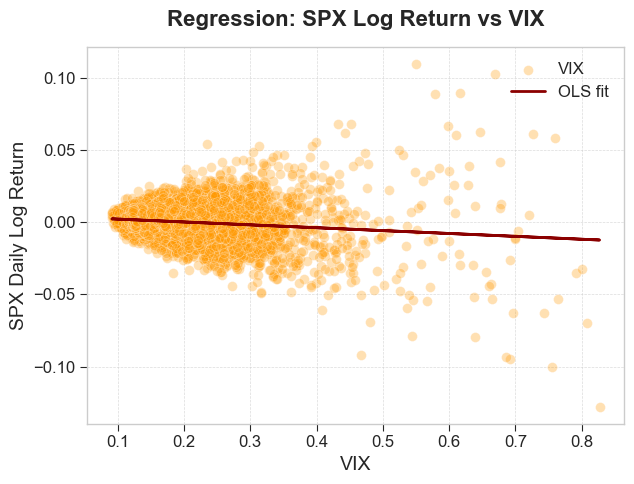


Results for regression: SPX log return vs Rolling_Vol
                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.811
Date:                Fri, 18 Apr 2025   Prob (F-statistic):             0.0510
Time:                        12:33:13   Log-Likelihood:                 16337.
No. Observations:                5505   AIC:                        -3.267e+04
Df Residuals:                    5503   BIC:                        -3.266e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

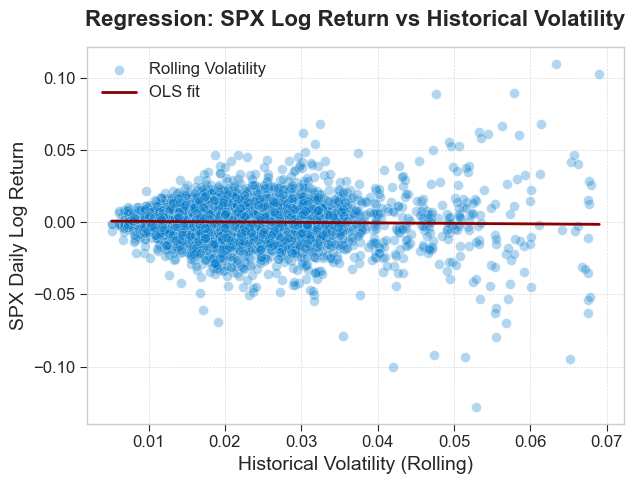

In [15]:
run_regression_plot(
    x_col="Close",
    x_label="VIX",
    color="#ff9900",
    label="VIX",
    title="Regression: SPX Log Return vs VIX",
    save_name="src/figures/p1/spx_vix"
)
run_regression_plot(
    x_col="Rolling_Vol",
    x_label="Historical Volatility (Rolling)",
    color="#007acc",
    label="Rolling Volatility",
    title="Regression: SPX Log Return vs Historical Volatility",
    save_name="src/figures/p1/spx_rollingvol"
)



## 3.1

### Simulation Helpers

In [2]:
from src.solutions.euler_black_scholes import EulerBlackScholes

# Automatically Orchestrate Multiple Runs

def run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, num_simulations):
    """Run multiple simulations with different hedging frequencies."""
    results = {}
    
    for interval in hedge_intervals:
        
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating {interval}-day hedging"):
            # Change up the seec
            np.random.seed(200 + i)
            
            # Run SIM
            model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
            sim_result = model.delta_hedge_short_call(K, interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[interval] = {
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

In [3]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Define hedging intervals to test
hedge_intervals = [1, 5, 21]  # Daily, weekly, and monthly

# Number of simulations
num_simulations = 10000

# Run simulations
results = run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, 
                                    num_simulations)

Simulating 21-day hedging: 100%|██████████| 10000/10000 [00:16<00:00, 607.09it/s]


In [ ]:
# Extract the P&L lists from results dictionary
pnl_1 = np.array(results[1]["all_pnl"])
pnl_5 = np.array(results[5]["all_pnl"])
pnl_21 = np.array(results[21]["all_pnl"])

def perform_f_test(data1, data2):
    # Calculate sample variances (unbiased estimator: ddof=1)
    var1 = np.var(data1, ddof=1)
    var2 = np.var(data2, ddof=1)
    
    # Identify which variance is larger for computing the F statistic
    if var1 >= var2:
        f_stat = var1 / var2
        dfn = len(data1) - 1  # degrees of freedom numerator
        dfd = len(data2) - 1  # degrees of freedom denominator
    else:
        f_stat = var2 / var1
        dfn = len(data2) - 1
        dfd = len(data1) - 1

    # Two-tailed p-value calculation
    p_value = 2 * (1 - stats.f.cdf(f_stat, dfn, dfd))
    
    # p_value should not exceed 1 
    p_value = min(p_value, 1.0)
    return f_stat, dfn, dfd, var1, var2, p_value

# Perform pairwise F-tests
f_1_5, dfn_1_5, dfd_1_5, var1, var5, p_1_5 = perform_f_test(pnl_1, pnl_5)
f_1_21, dfn_1_21, dfd_1_21, var1_again, var21, p_1_21 = perform_f_test(pnl_1, pnl_21)
f_5_21, dfn_5_21, dfd_5_21, var5_again, var21_again, p_5_21 = perform_f_test(pnl_5, pnl_21)

# Create an overview report 
report = f"""
F-Test Results for Variance Comparison of Final P&L Values:

1. **Comparison between results[1]['all_pnl'] and results[5]['all_pnl']:**
   - Variance for key 1: {var1:.4f}
   - Variance for key 5: {var5:.4f}
   - F Statistic: {f_1_5:.4f} (with degrees of freedom {dfn_1_5} and {dfd_1_5})
   - p-value: {p_1_5:.4f}
   => {'Variances differ significantly (reject H0)' if p_1_5 < 0.05 else 'No significant difference in variances (fail to reject H0)'}

2. **Comparison between results[1]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 1: {var1_again:.4f}
   - Variance for key 21: {var21:.4f}
   - F Statistic: {f_1_21:.4f} (with degrees of freedom {dfn_1_21} and {dfd_1_21})
   - p-value: {p_1_21:.4f}
   => {'Variances differ significantly (reject H0)' if p_1_21 < 0.05 else 'No significant difference in variances (fail to reject H0)'}

3. **Comparison between results[5]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 5: {var5_again:.4f}
   - Variance for key 21: {var21_again:.4f}
   - F Statistic: {f_5_21:.4f} (with degrees of freedom {dfn_5_21} and {dfd_5_21})
   - p-value: {p_5_21:.4f}
   => {'Variances differ significantly (reject H0)' if p_5_21 < 0.05 else 'No significant difference in variances (fail to reject H0)'}
"""

print(report)

# Assume pnl_1, pnl_5, and pnl_21 are numpy arrays of your data
sw_stat_1, sw_pvalue_1 = stats.shapiro(pnl_1)
sw_stat_5, sw_pvalue_5 = stats.shapiro(pnl_5)
sw_stat_21, sw_pvalue_21 = stats.shapiro(pnl_21)


print()
print("Shapiro-Wilk Test:")
print(f"Results[1]['all_pnl']: Statistic={sw_stat_1:.4f}, p-value={sw_pvalue_1:.4f}")
print(f"Results[5]['all_pnl']: Statistic={sw_stat_5:.4f}, p-value={sw_pvalue_5:.4f}")
print(f"Results[21]['all_pnl']: Statistic={sw_stat_21:.4f}, p-value={sw_pvalue_21:.4f}")

# Calculate means for each group
mean_1 = np.mean(pnl_1)
mean_5 = np.mean(pnl_5)
mean_21 = np.mean(pnl_21)

# Print the mean values
print()
print("Mean of each group:")
print(f"Results[1]['all_pnl']: {mean_1:.4f}")
print(f"Results[5]['all_pnl']: {mean_5:.4f}")
print(f"Results[21]['all_pnl']: {mean_21:.4f}")

# Perform Welch's t-tests for each pair
t_stat_1_5, p_val_1_5 = stats.ttest_ind(pnl_1, pnl_5, equal_var=False)
t_stat_1_21, p_val_1_21 = stats.ttest_ind(pnl_1, pnl_21, equal_var=False)
t_stat_5_21, p_val_5_21 = stats.ttest_ind(pnl_5, pnl_21, equal_var=False)

# Print the results
print()
print("Results of pairwise t-tests (Welch's t-test):")
print(f"Comparison between results[1]['all_pnl'] and results[5]['all_pnl']: t-statistic = {t_stat_1_5:.4f}, p-value = {p_val_1_5:.4f}")
print(f"Comparison between results[1]['all_pnl'] and results[21]['all_pnl']: t-statistic = {t_stat_1_21:.4f}, p-value = {p_val_1_21:.4f}")
print(f"Comparison between results[5]['all_pnl'] and results[21]['all_pnl']: t-statistic = {t_stat_5_21:.4f}, p-value = {p_val_5_21:.4f}")

# Perform one-sample t-tests for mean = 0
t_1, p_1 = stats.ttest_1samp(pnl_1, 0)
t_5, p_5 = stats.ttest_1samp(pnl_5, 0)
t_21, p_21 = stats.ttest_1samp(pnl_21, 0)

# Print results
print()
print("One-sample t-tests (H0: mean = 0):")
print(f"Results[1]['all_pnl']: t = {t_1:.4f}, p = {p_1:.4f}")
print(f"Results[5]['all_pnl']: t = {t_5:.4f}, p = {p_5:.4f}")
print(f"Results[21]['all_pnl']: t = {t_21:.4f}, p = {p_21:.4f}")



F-Test Results for Variance Comparison of Final P&L Values:

1. **Comparison between results[1]['all_pnl'] and results[5]['all_pnl']:**
   - Variance for key 1: 0.1830
   - Variance for key 5: 0.8575
   - F Statistic: 4.6870 (with degrees of freedom 9999 and 9999)
   - p-value: 0.0000
   => Variances differ significantly (reject H0)

2. **Comparison between results[1]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 1: 0.1830
   - Variance for key 21: 3.6012
   - F Statistic: 19.6830 (with degrees of freedom 9999 and 9999)
   - p-value: 0.0000
   => Variances differ significantly (reject H0)

3. **Comparison between results[5]['all_pnl'] and results[21]['all_pnl']:**
   - Variance for key 5: 0.8575
   - Variance for key 21: 3.6012
   - F Statistic: 4.1995 (with degrees of freedom 9999 and 9999)
   - p-value: 0.0000
   => Variances differ significantly (reject H0)


Shapiro-Wilk Test:
Results[1]['all_pnl']: Statistic=0.9814, p-value=0.0000
Results[5]['all_pnl']: Statistic

### Visualisations

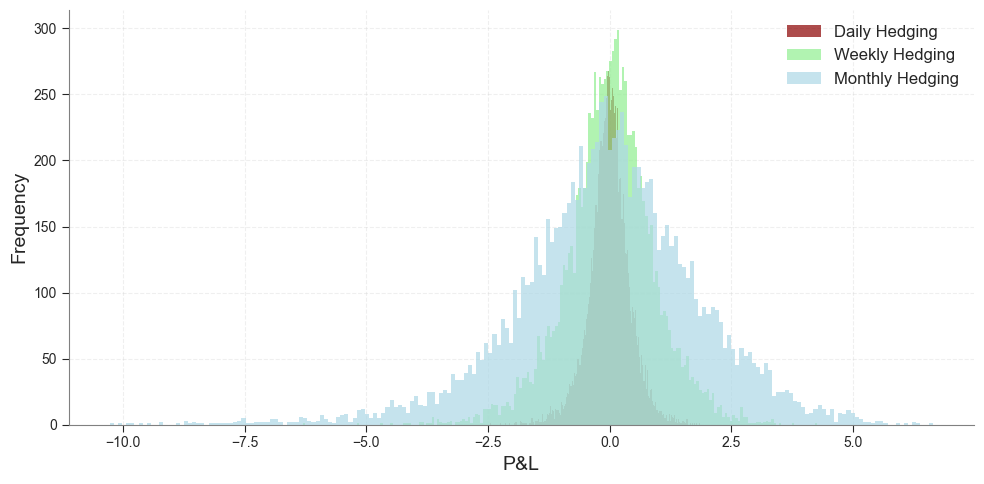

In [ ]:
# 1. P&L Distribution Comparison
plt.figure(figsize=(10, 5))
colors = ['darkred', 'lightgreen', 'lightblue']
for i, interval in enumerate(hedge_intervals):
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
        
    plt.hist(results[interval]['all_pnl'], bins=200, alpha=0.7, 
             color=colors[i], label=f"{interval_desc} Hedging")

# Apply styling
fs.plot_distribution(
                    xlabel='P&L', ylabel='Frequency')

fs.finalize_plot(filename="src/figures/p3/pl_distr_by_hedge_freq")
plt.legend()
plt.show()

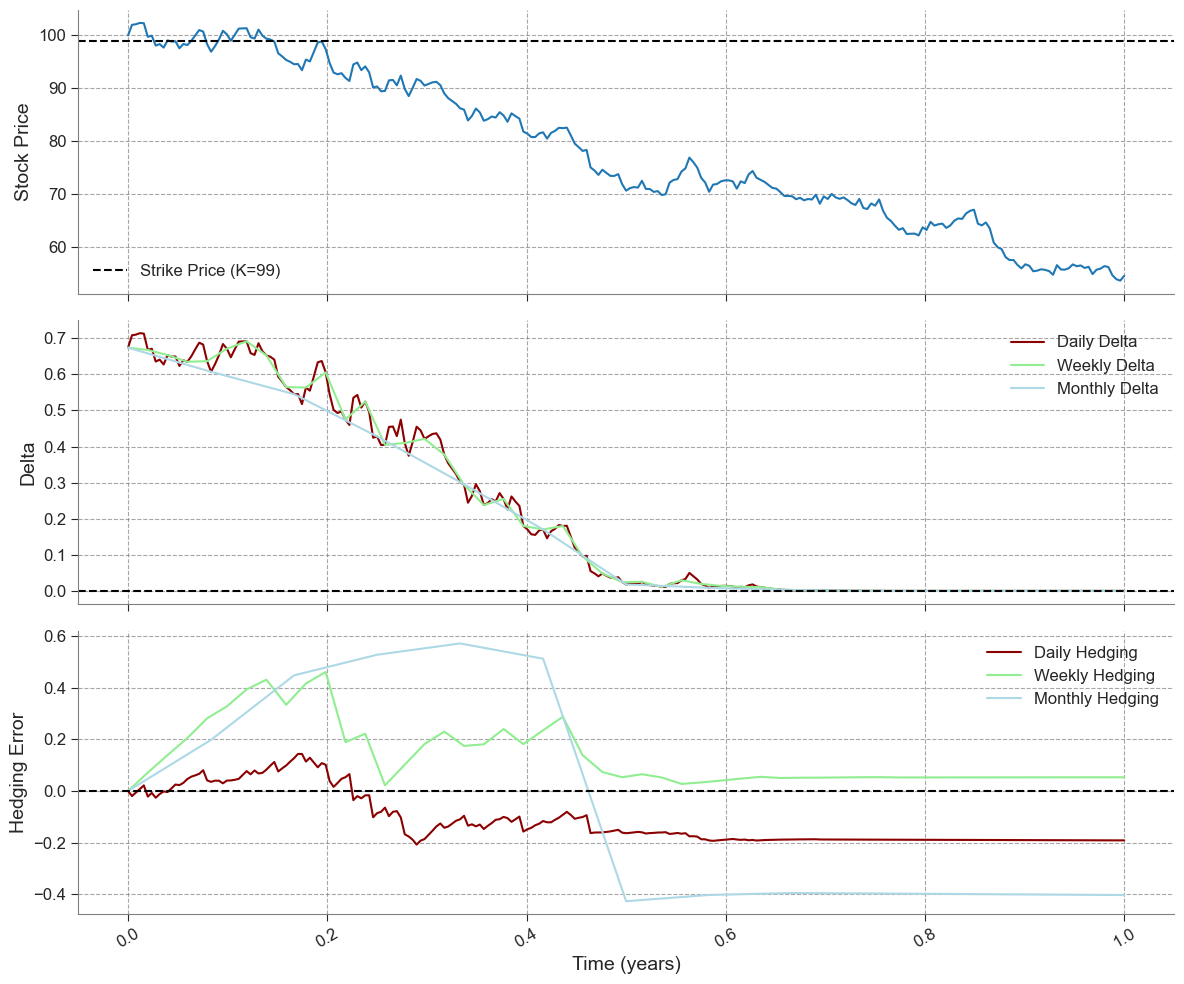

In [ ]:
# 2. Single Simulation Analysis with Different Frequencies
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

seed = 14
# Use same seed for all simulations to compare hedging frequency effect on same path
np.random.seed(seed)
# Simulate stock path once
model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
time, stock_path = model.simulate()

# Stock path plot
ax1.plot(time, stock_path)
ax1.axhline(y=K, color='black', linestyle='--', label=f'Strike Price (K={K})')
fs.plot_timeseries(ax=ax1, ylabel='Stock Price')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
ax1.legend()

# Colors for each frequency
colors = ['darkred', 'lightgreen', 'lightblue']

# Loop over frequencies 
for i, interval in enumerate(hedge_intervals):
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
    
    # Re‑seed so each freq uses the same stock path
    np.random.seed(seed)
    model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
    sim = model.delta_hedge_short_call(K, interval)
    
    # Delta plot
    ax2.plot(sim['hedge_times'], sim['delta_values'],
             label=f"{interval_desc} Delta",
             color=colors[i])
    
    # Hedging error plot
    min_length = min(len(sim['portfolio_values']), len(sim['option_values']))
    hedging_error = sim['portfolio_values'][:min_length] \
                  - sim['option_values'][:min_length]
    ax3.plot(sim['hedge_times'][:min_length], hedging_error,
             label=f"{interval_desc} Hedging",
             color=colors[i])

# Delta plot
fs.plot_timeseries(ax=ax2, ylabel='Delta')
ax2.legend(loc='upper right')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# Hedging error plot
fs.plot_timeseries(ax=ax3, xlabel='Time (years)', ylabel='Hedging Error')
ax3.axhline(y=0, color='black', linestyle='--')
ax3.legend(loc='upper right')
ax3.grid(True, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

fs.finalize_plot(fig=fig, filename="src/figures/p3/stock_price_path")
plt.show()
plt.close()



In [ ]:
# Set parameters
num_simulations = 10000
hedge_intervals = [1, 5, 21]
hedge_labels = {1: "Daily", 5: "Weekly", 21: "Monthly"}

# Initialize storage for results
hedging_errors = {interval: [] for interval in hedge_intervals}
hedge_times_dict = {interval: None for interval in hedge_intervals}

# Run simulations
for sim_num in range(num_simulations):
    np.random.seed(200 + sim_num) 

    # Generate stock path once per simulation
    model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
    time, stock_path = model.simulate()

    for interval in hedge_intervals:
        # Use the same stock path, not a new model for each interval
        sim = model.delta_hedge_short_call(K, interval)

        # Align lengths for hedging error computation
        min_length = min(len(sim['portfolio_values']), len(sim['option_values']))
        error = np.array(sim['portfolio_values'][:min_length]) - np.array(sim['option_values'][:min_length])
        hedging_errors[interval].append(error)

        # Save hedge times once per interval
        if (hedge_times_dict[interval] is None or 
            len(hedge_times_dict[interval]) < len(sim['hedge_times'][:min_length])):
            hedge_times_dict[interval] = sim['hedge_times'][:min_length]




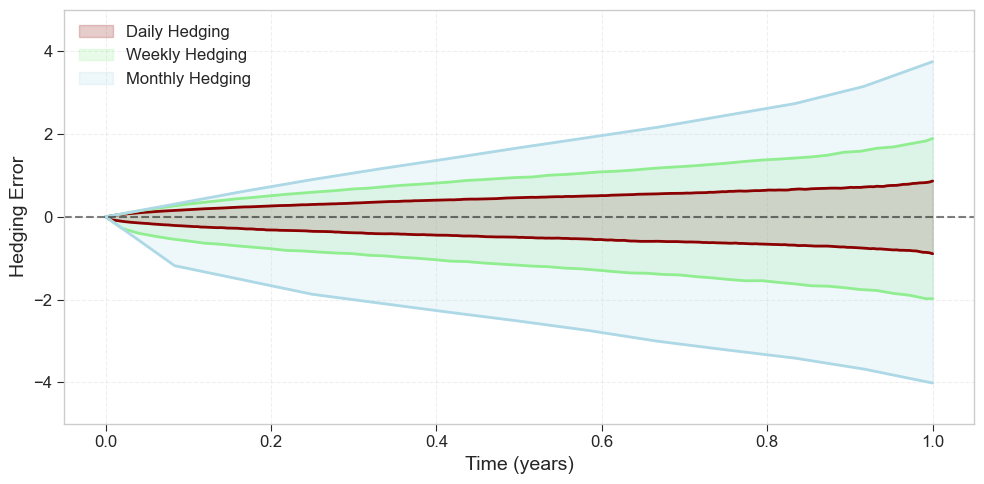

In [ ]:
# Plotting mean + 95% prediction interval of hedging error per interval
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['darkred', 'lightgreen', 'lightblue']

for i, interval in enumerate(hedge_intervals):
    errors = np.vstack(hedging_errors[interval])   
    times  = np.array(hedge_times_dict[interval])

    mean_error = errors.mean(axis=0)
    # 95% prediction bounds
    lower_pi = np.percentile(errors,  2.5, axis=0)
    upper_pi = np.percentile(errors, 100-2.5, axis=0)

    # fill prediction band
    ax.fill_between(times, lower_pi, upper_pi, color=colors[i], alpha=0.2, label=f"{hedge_labels[interval]} Hedging")
    ax.plot(times, upper_pi, color=colors[i], linewidth=2)
    ax.plot(times, lower_pi, color=colors[i], linewidth=2)


# finalize
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Hedging Error")
ax.set_ylim(-5, 5)   
ax.legend()
plt.tight_layout()
plt.show()



In [1]:
# 3. Scatter plot of P&L vs. Hedging Frequency [Not used for report]
plt.figure(figsize=(10, 6))
mean_pnls = [results[interval]['mean_pnl'] for interval in hedge_intervals]
std_pnls = [results[interval]['std_pnl'] for interval in hedge_intervals]
plt.errorbar(hedge_intervals, mean_pnls, yerr=std_pnls, fmt='o-', capsize=5, 
            color=fs.colors['neutral'], ecolor=fs.colors['highlight'])
# plt.xscale('log')

# Add annotations with standard deviations
for i, interval in enumerate(hedge_intervals):
    fs.annotate_point(plt.gca(), interval, mean_pnls[i], 
                     f'σ = {std_pnls[i]:.4f}', 
                     fc='#ffed6f', alpha=0.7)

# Apply styling and finalize
fs.style_errorbar(title='Mean P&L vs. Hedging Frequency', 
                 xlabel='Hedging Interval (days)', ylabel='Mean P&L')
fs.finalize_plot(filename="src/figures/p3/mean_pl_vs_hedge_freq")
plt.show()


NameError: name 'hedge_intervals' is not defined

<Figure size 1000x600 with 0 Axes>

## 3.2

### Simulation Helpers 

In [7]:
def get_key(vol_true, vol_model):
    return f"true/model [{vol_true:.2f}/{vol_model:.2f}]"

def run_volatility_mismatch_simulations(S0, K, r, T, N, hedge_interval, 
                                        vol_true_list, vol_model_list, num_simulations):
    """
    Run simulations with different combinations of true and model volatilities.
    
    Parameters:
    S0, K, r, T, N : Standard Black-Scholes parameters
    hedge_interval : Frequency of hedging adjustments
    vol_true_list : List of true volatilities for simulation
    vol_model_list : List of model volatilities for pricing/hedging
    num_simulations : Number of simulations for each volatility combination
    
    Returns:
    dict: Results organized by volatility combinations
    """
    results = {}
    
    # Create a meshgrid of all volatility combinations
    from itertools import product
    vol_combinations = list(product(vol_true_list, vol_model_list))
    
    for vol_true, vol_model in vol_combinations:
        key = get_key(vol_true,vol_model)
        
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating for {key}"):
            # Set a different seed for each simulation
            np.random.seed(i)
            
            # Create model and run simulation
            model = EulerBlackScholes(S0, r, vol_true, vol_model, T, N)
            sim_result = model.delta_hedge_short_call(K, hedge_interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[key] = {
            'true_vol': vol_true,
            'model_vol': vol_model,
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

def analyze_single_path(S0, K, r, T, N, hedge_interval, vol_true, vol_model_list):
    """Analyze a single price path with different model volatilities."""
    results = {}
    
    # Generate one price path with the true volatility
    np.random.seed(42)  # For reproducibility
    base_model = EulerBlackScholes(S0, r, vol_true, vol_true, T, N)
    time, S = base_model.simulate()
    
    # Use this same path with different model volatilities
    for vol_model in vol_model_list:
        model = EulerBlackScholes(S0, r, vol_true, vol_model, T, N)
        
        # Override the simulate method to use our pre-generated path
        original_simulate = model.simulate
        model.simulate = lambda: (time, S)
        
        # Run the hedging simulation
        sim_result = model.delta_hedge_short_call(K, hedge_interval)
        
        # Store results
        key = get_key(vol_true,vol_model)
        results[key] = {
            'true_vol': vol_true,
            'model_vol': vol_model,
            'final_pnl': sim_result['final_pnl'],
            'portfolio_values': sim_result['portfolio_values'],
            'option_values': sim_result['option_values'],
            'delta_values': sim_result['delta_values'],
            'hedge_times': sim_result['hedge_times']
        }
        
        # Restore original method
        model.simulate = original_simulate
    
    return time, S, results

In [9]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Hedging frequency
hedge_interval = 5  # Weekly hedging

# Volatility lists to test
vol_true_list = [0.10, 0.20, 0.30]  # True volatilities
vol_model_list = [0.10, 0.20, 0.30]  # Model volatilities

# Number of simulations
num_simulations = 100000

results = run_volatility_mismatch_simulations(S0, K, r, T, N, hedge_interval, vol_true_list, vol_model_list, num_simulations)

### Visualisations

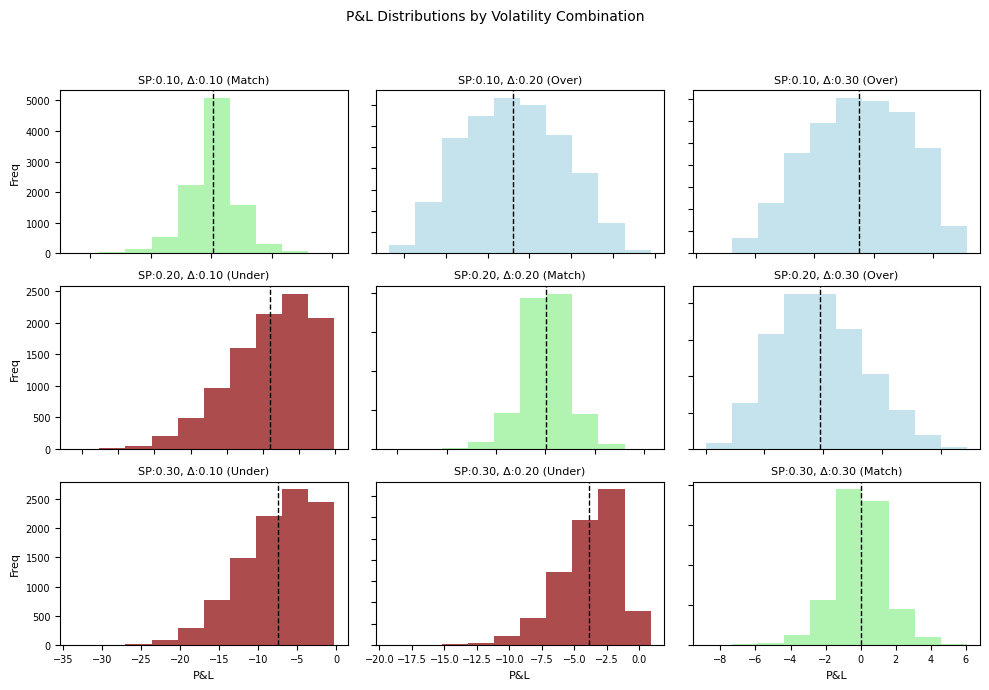

In [10]:
# 4. Visualize P&L distributions for different volatility combinations
fig = plt.figure(figsize=(10, 7))  # Reduced overall figure size

# Create a grid for subplots - one row for each true volatility
num_true_vols = len(vol_true_list)
num_model_vols = len(vol_model_list)

colors = ['darkred', 'lightgreen', 'lightblue']

for i, vol_true in enumerate(vol_true_list):
    for j, vol_model in enumerate(vol_model_list):
        key = get_key(vol_true, vol_model)
        
        # Create subplot
        ax = plt.subplot(num_true_vols, num_model_vols, i*num_model_vols + j + 1)
        
        # Calculate hedging bias
        bias = vol_model - vol_true
        
        # Choose color based on bias
        if bias == 0:
            color = colors[1]
        elif bias < 0:
            color = colors[0]
        else:
            color = colors[2]
            
        bias_text = "Over" if bias > 0 else "Under" if bias < 0 else "Match"
        
        # Plot histogram with fewer bins
        plt.hist(results[key]['all_pnl'], bins=10, alpha=0.7, color=color)
        plt.axvline(results[key]['mean_pnl'], color='k', linestyle='--', linewidth=1)
        
        # Simplify titles and labels
        ax.set_title(f"SP:{vol_true:.2f}, Δ:{vol_model:.2f} ({bias_text})", fontsize=8)
        
        # Only show x and y labels on edge plots
        if i == num_true_vols-1:
            ax.set_xlabel('P&L', fontsize=8)
        else:
            ax.set_xticklabels([])
            
        if j == 0:
            ax.set_ylabel('Freq', fontsize=8)
        else:
            ax.set_yticklabels([])
        
        # Reduce tick size
        ax.tick_params(axis='both', which='major', labelsize=7)
        

plt.suptitle('P&L Distributions by Volatility Combination', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Reduce spacing between subplots
plt.savefig("src/figures/p3/pl_for_diff_volatility_combos")
plt.show()

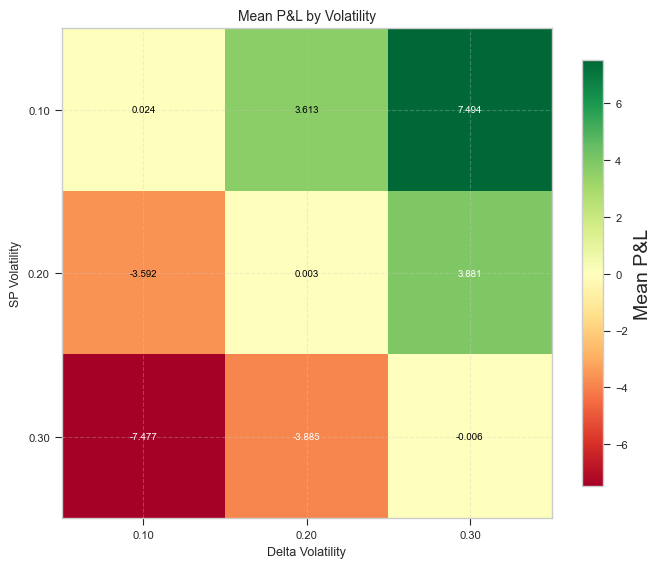

In [13]:
# 5. Heat map of mean P&L
plt.figure(figsize=(7, 6))  # Reduced figure size

# Prepare data for heatmap
heatmap_data = np.zeros((len(vol_true_list), len(vol_model_list)))
for i, vol_true in enumerate(vol_true_list):
    for j, vol_model in enumerate(vol_model_list):
        key = get_key(vol_true, vol_model)
        heatmap_data[i, j] = results[key]['mean_pnl']

# Create heatmap with RdYlGn colormap (red-yellow-green) instead of custom fs.cmap_ryg
ax = plt.gca()
im = plt.imshow(heatmap_data, cmap='RdYlGn', interpolation='nearest')
cbar = plt.colorbar(im, label='Mean P&L', shrink=0.8)  # Smaller colorbar
cbar.ax.tick_params(labelsize=8)  # Smaller colorbar ticks

# Set labels with smaller font
plt.xticks(np.arange(len(vol_model_list)), [f"{v:.2f}" for v in vol_model_list], fontsize=8)
plt.yticks(np.arange(len(vol_true_list)), [f"{v:.2f}" for v in vol_true_list], fontsize=8)

# Add title and axis labels
plt.title('Mean P&L by Volatility', fontsize=10)
plt.xlabel('Delta Volatility', fontsize=9)
plt.ylabel('SP Volatility', fontsize=9)

# Add text annotations with smaller, more readable values
for i in range(len(vol_true_list)):
    for j in range(len(vol_model_list)):
        value = heatmap_data[i, j]
        text_color = 'white' if abs(value) > np.max(np.abs(heatmap_data))/2 else 'black'
        ax.text(j, i, f"{value:.3f}", ha="center", va="center", 
                color=text_color, fontsize=7)  # Reduced decimal places and font size

# Finalize with tight layout
plt.tight_layout()
plt.savefig("src/figures/p3/mean_pl_volatilities")
plt.show()

##